<a href="https://colab.research.google.com/github/emanueleusai/CS4RI/blob/master/CODER/ParticleImages/Particle_Images_Tutorial.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Particle Images 
*   One of the important aspects of searches for new physics at the Large Hadron Collider (LHC) involves the classification of various High-Energy Particles in collision events
*   In this notebook we develop a model which classifies electron and photon electromagnetic showers as accurately as possible based on the detector images provided in the dataset below (one pixel = one channel of the detector)
*   We will be evaluating the performance of the model using a ROC curve (Receiver Operating Characteristic curve) and the AUC (Area Under the ROC Curve) score.
*   We are using Keras Framework in this sample notebook, one of the most popular Machine Learning / Deep Learning Frameworks. 



## Create the appropriate project folder 

In [1]:
mkdir Particle_Images

mkdir: cannot create directory ‘Particle_Images’: File exists


In [2]:
cd Particle_Images

/content/Particle_Images


In [3]:
mkdir data/

mkdir: cannot create directory ‘data/’: File exists


# Download the Dataset

In [4]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2021-03-24 06:33:04--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 137.138.120.151, 188.184.97.72, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82.98M  19.3MB/s    in 4.3s    

Last-modified header invalid -- time-stamp ignored.
2021-03-24 06:33:11 (19.3 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2021-03-24 06:33:11--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.170.17, 128.142.53.35, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.170.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391

# Import modules

In [5]:
import numpy as np
np.random.seed(1234)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Keras Model Parameters

In [6]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 1024     # Training size
valid_size  = 1024     # Validation size
test_size   = 1024     # Test size
epochs      = 20       # Number of epochs

# Load Image Data
### Two classes of particles: electrons and photons
### 32x32 matrices (two channels - hit energy and time) for the two classes of particles electrons and photons impinging on a calorimeter (one calorimetric cell = one pixel).
#### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

In [7]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    return X, y

# Configure Training / Validation / Test Sets

In [8]:
# Set range of training set
train_start, train_stop = 0, train_size
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
X_test, y_test = load_data(decays,test_start,test_stop)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


# Plot sample of training images
### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

Here we show energy and time images for a photon:

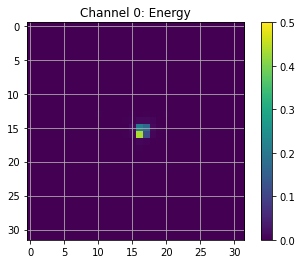

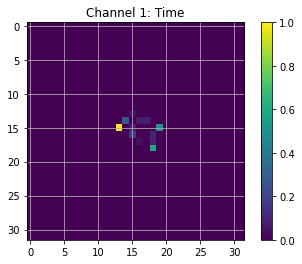

In [9]:
# plt.set_cmap('nipy_spectral')
plt.set_cmap('viridis')

plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)
plt.clim(0,0.5)
plt.colorbar()
plt.show()

plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1: Time")  # Time
plt.grid(True)
plt.clim(0,1)
plt.colorbar()
plt.show()

And for an electron:

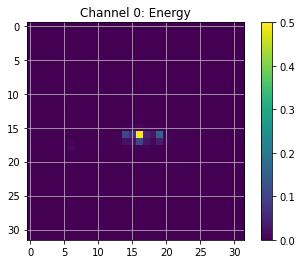

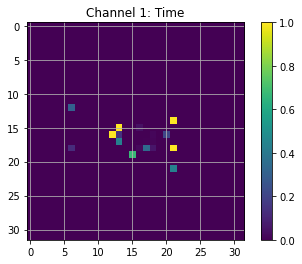

In [10]:
# plt.set_cmap('nipy_spectral')
plt.set_cmap('viridis')

plt.imshow(X_train[-3,:,:,0])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)
plt.clim(0,0.5)
plt.colorbar()
plt.show()

plt.imshow(X_train[-3,:,:,1])
plt.title("Channel 1: Time")  # Time
plt.grid(True)
plt.clim(0,1)
plt.colorbar()
plt.show()

# Define CNN Model
## You can experiment with the model and try various architectures.  

In [11]:
### Define Convolutional Neural Network (CNN) Model ###

model = Sequential()
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        304       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

## Train the Model
### Try optimizing the model by changing the hyper-parameters to achieve the best performance possible.

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Epoch 1/20
32/32 [==============================] - 31s 20ms/step - loss: 0.6932 - accuracy: 0.4862 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/20
32/32 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.5125 - val_loss: 0.6904 - val_accuracy: 0.5083
Epoch 3/20
32/32 [==============================] - 0s 8ms/step - loss: 0.6877 - accuracy: 0.5437 - val_loss: 0.6812 - val_accuracy: 0.5635
Epoch 4/20
32/32 [==============================] - 0s 8ms/step - loss: 0.6689 - accuracy: 0.5718 - val_loss: 0.6869 - val_accuracy: 0.5669
Epoch 5/20
32/32 [==============================] - 0s 8ms/step - loss: 0.6529 - accuracy: 0.6106 - val_loss: 0.6706 - val_accuracy: 0.5840
Epoch 6/20
32/32 [==============================] - 0s 8ms/step - loss: 0.6529 - accuracy: 0.5991 - val_loss: 0.6716 - val_accuracy: 0.5952
Epoch 7/20
32/32 [==============================] - 0s 8ms/step - loss: 0.6483 - accuracy: 0.6230 - val_loss: 0.6816 - val_accuracy: 0.5737
Epoch 8/20
32/32 [

## Evaluate the Model  
### Along with the model accuracy, the prefered metric for evaluation is ROC (Receiver Operating Characteristic) curve and the AUC score (Area under the ROC Curve).

In [13]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

64/64 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5942

Validation loss / accuracy: 0.6811 / 0.5942
Validation ROC AUC: 0.6205978393554688
64/64 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5884

Test loss / accuracy: 0.6859 / 0.5884
Test ROC AUC: 0.615962028503418


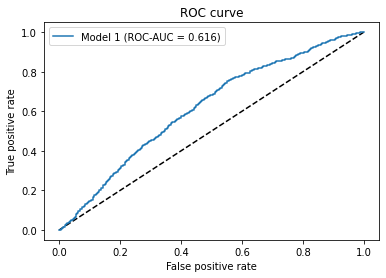

In [14]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()